In [1]:
%pip install haystack-ai
%pip install python-pptx
%pip install python-docx
%pip install pypdf
%pip install trafilatura
%pip install unstructured-client
%pip install unstructured-fileconverter-haystack
%pip install unstructured
%pip install tika
%pip install sentence-transformers>=2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.9/351.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Prompt Templates & Queries/Instructions

In [2]:
# Prompt templates
text_template = """
You are a technical writer tasked with updating an outdated user guide for a product/service.
Your task is to update an outdated user guide by incorporating relevant information from the provided reference material.
Only generate the content that is to be used in this updated user guide.
Do not provide explanations or notes.

Given the following information, complete the task.

Outdated User Guide: {{ documents[0].content }}
Reference Material: {{ documents[1].content }}

Task: {{ query }}?
"""

slides_template = """
You are an assistant tasked with generating JSON data required by the user for creating slides.
Your task is to generate only the JSON data based on the updated content provided.
Do not include any additional text or explanations.

Context:
Updated Content:
{% for doc in documents %}
    {% if doc.meta['name'] == 'updated' %}
        {{ doc.content }}
    {% endif %}
{% endfor %}

Task: {{ query }}?
"""

script_template = """
You are a skilled scriptwriter tasked with crafting a clear, engaging, professional, and conversational script intended for a corporate training video. Your role is to create content that is simple and accessible, while ensuring the instructional integrity of the material. As you write, focus on maintaining a friendly yet authoritative tone. Ensure that the final output is polished and suitable for direct reading by a text-to-speech (TTS) model. Remove any bracketed text, stage directions, or any content that would not be read directly from the script. The output should not include introductory phrases or descriptions of the script content.

Context:
Updated Content:
{% for doc in documents %}
    {% if doc.meta['name'] == 'updated' %}
        {{ doc.content }}
    {% endif %}
{% endfor %}

Task: {{ query }}?
"""

# Queries
text_query = """
Update an outdated user guide by incorporating relevant information from the provided reference material.
"""
slides_query = """
Generate a 10 slide presentation for the user guide.
"""

script_query = """
Generate a polished script for a corporate training video based on the updated content. Ensure the script is clear, engaging, and professional, and is suitable for direct reading by a text-to-speech (TTS) voice. Exclude any introductory phrases or descriptions, and remove content that is not meant for direct reading.
"""

# Generate Text for Documents, Slides and TTS Script

In [3]:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack import Document
from haystack.components.converters.txt import TextFileToDocument
from haystack.utils import Secret
import os

Preprocessing step: Load files and convert them to Documents, a Haystack data class.

https://docs.haystack.deepset.ai/docs/data-classes#document

In [4]:
# Convert .txt to Document object (not .docx)
converter = TextFileToDocument()
results = converter.run(sources=["reference.txt", "outdated.txt"])

# Add Documents to the InMemoryDocumentStore
documents = results["documents"]
docstore = InMemoryDocumentStore()
docstore.write_documents([Document(content=documents[0].content), Document(content=documents[1].content)])

2

Create an LLM component for inference

In [6]:
os.environ["GROQ_OPENAI_API_KEY"]="<GROQ_API_KEY>" # Replace with your Groq API key
api_key=os.getenv("GROQ_OPENAI_API_KEY")

def llm_component(temp):
    return OpenAIGenerator(
        api_key=Secret.from_env_var("GROQ_OPENAI_API_KEY"),
        api_base_url="https://api.groq.com/openai/v1",
        model="llama3-8b-8192", # Llama 3 - Groq Model
        generation_kwargs={"temperature": temp}  # TEMP 0.2 "n":2
    )

Create a query pipeline where each component's output becomes the input for the next.

In [ ]:
# Pipeline function for generating text for training material, user guides, powerpoint data(JSON), and TTS script
def inference_pipeline(query, template, docstore, temp=0.2):
    llm = llm_component(temp)
    pipe = Pipeline()
    pipe.add_component("retriever", InMemoryBM25Retriever(document_store=docstore))
    pipe.add_component("prompt_builder", PromptBuilder(template=template))
    pipe.add_component("llm", llm)
    pipe.connect("retriever", "prompt_builder.documents") # prompt_builder component will take the content
    pipe.connect("prompt_builder", "llm")

    res = pipe.run({"retriever": {"query": query},"prompt_builder": {"query": query}})

    # Returns the LLM generated response
    return res['llm']['replies'][0]

### inference_pipeline Graph
1. **Retriever Component**: The retriever fetches documents from the document_store based on the input query.
2. **Connecting to PromptBuilder**: The retrieved documents are passed to the PromptBuilder via the documents input.
3. **PromptBuilder Component**: The PromptBuilder uses these documents and the specified template to build a structured prompt.
4. **LLM Inference**: The prompt is sent to the llm component for inference.

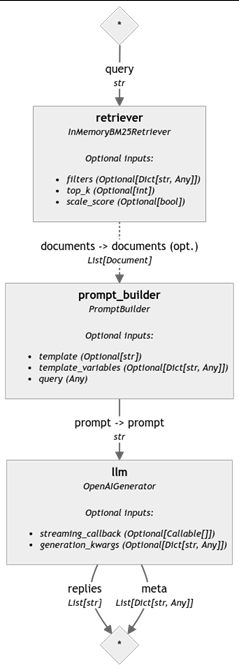

### Run the Pipeline to generate text

In [7]:
# Text for User Guides & Training Manuals

# Call inference_pipline function
generate_text = inference_pipeline(text_query, text_template, docstore) # Pass query and prompt template
print(generate_text)

 # Store the response in the document store. You would only do this if you want to generate content(guides, slides, and scripts) from outdated and reference.
documents = str(generate_text)
docstore.write_documents([Document(content=documents, meta={"name": "updated"})])

Here is the updated user guide:

1. Unbox the Blood Pressure Monitor: Remove the monitor, cuff, power adapter, and user manual from the packaging. Place them on a clean, flat surface.

2. Read the User Manual: Before setting up, read through the user manual to familiarize yourself with the device and its features.

3. Attach the Smart Cuff: Connect the updated cuff to the monitor using the new easy-connect feature.

4. Power On the Device: Use the USB-C power adapter to connect the monitor to a power source and press the touch-sensitive power button.

5. Measure Blood Pressure: The device performs automatic calibration upon startup. No manual calibration needed. Follow on-screen instructions to place the updated cuff on the patient’s arm and press the “Measure” button.

6. Prepare the Patient: Ensure the patient is seated comfortably with their arm at heart level. Place the cuff around the patient’s upper arm, ensuring it is snug but not too tight.

7. Take a Measurement: Press the “Me

1

### Creating Text for Slides

In [8]:
# Text for Slides

generate_slides = inference_pipeline(slides_query, slides_template, docstore, temp=0.5)
print(generate_slides)

[
    {
        "title": "Unboxing the Blood Pressure Monitor",
        "content": "Remove the monitor, cuff, power adapter, and user manual from the packaging. Place them on a clean, flat surface."
    },
    {
        "title": "Read the User Manual",
        "content": "Before setting up, read through the user manual to familiarize yourself with the device and its features."
    },
    {
        "title": "Attaching the Smart Cuff",
        "content": "Connect the updated cuff to the monitor using the new easy-connect feature."
    },
    {
        "title": "Powering On the Device",
        "content": "Use the USB-C power adapter to connect the monitor to a power source and press the touch-sensitive power button."
    },
    {
        "title": "Measuring Blood Pressure",
        "content": "The device performs automatic calibration upon startup. No manual calibration needed. Follow on-screen instructions to place the updated cuff on the patient’s arm and press the “Measure” button."
 

### Creating Text for Text-to-Speech Scripts

In [9]:
# Text for text-to-speech Script

generate_script = inference_pipeline(script_query, script_template, docstore, temp=0.6)
print(generate_script)

Here is the polished script for the corporate training video:

Unbox the Blood Pressure Monitor

Remove the monitor, cuff, power adapter, and user manual from the packaging. Place them on a clean, flat surface.

Read the User Manual

Before setting up, read through the user manual to familiarize yourself with the device and its features.

Attach the Smart Cuff

Connect the updated cuff to the monitor using the new easy-connect feature.

Power On the Device

Use the USB-C power adapter to connect the monitor to a power source and press the touch-sensitive power button.

Measure Blood Pressure

The device performs automatic calibration upon startup. No manual calibration needed. Follow on-screen instructions to place the updated cuff on the patient's arm and press the "Measure" button.

Prepare the Patient

Ensure the patient is seated comfortably with their arm at heart level. Place the cuff around the patient's upper arm, ensuring it is snug but not too tight.

Take a Measurement

Pres

# Creating Indexing Pipeline
**The FileTypeRouter selects the appropriate converter based on the uploaded file type.**

Indexing for the following file types:

* TXT (https://docs.haystack.deepset.ai/reference/converters-api#textfiletodocument)
* DOCX (https://docs.haystack.deepset.ai/reference/converters-api#docxtodocument)
* PDF (https://docs.haystack.deepset.ai/reference/converters-api#module-pypdf)
* PPTX (https://docs.haystack.deepset.ai/reference/converters-api#module-pptx)

FileTypeRouter mime_types

- https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types/Common_types

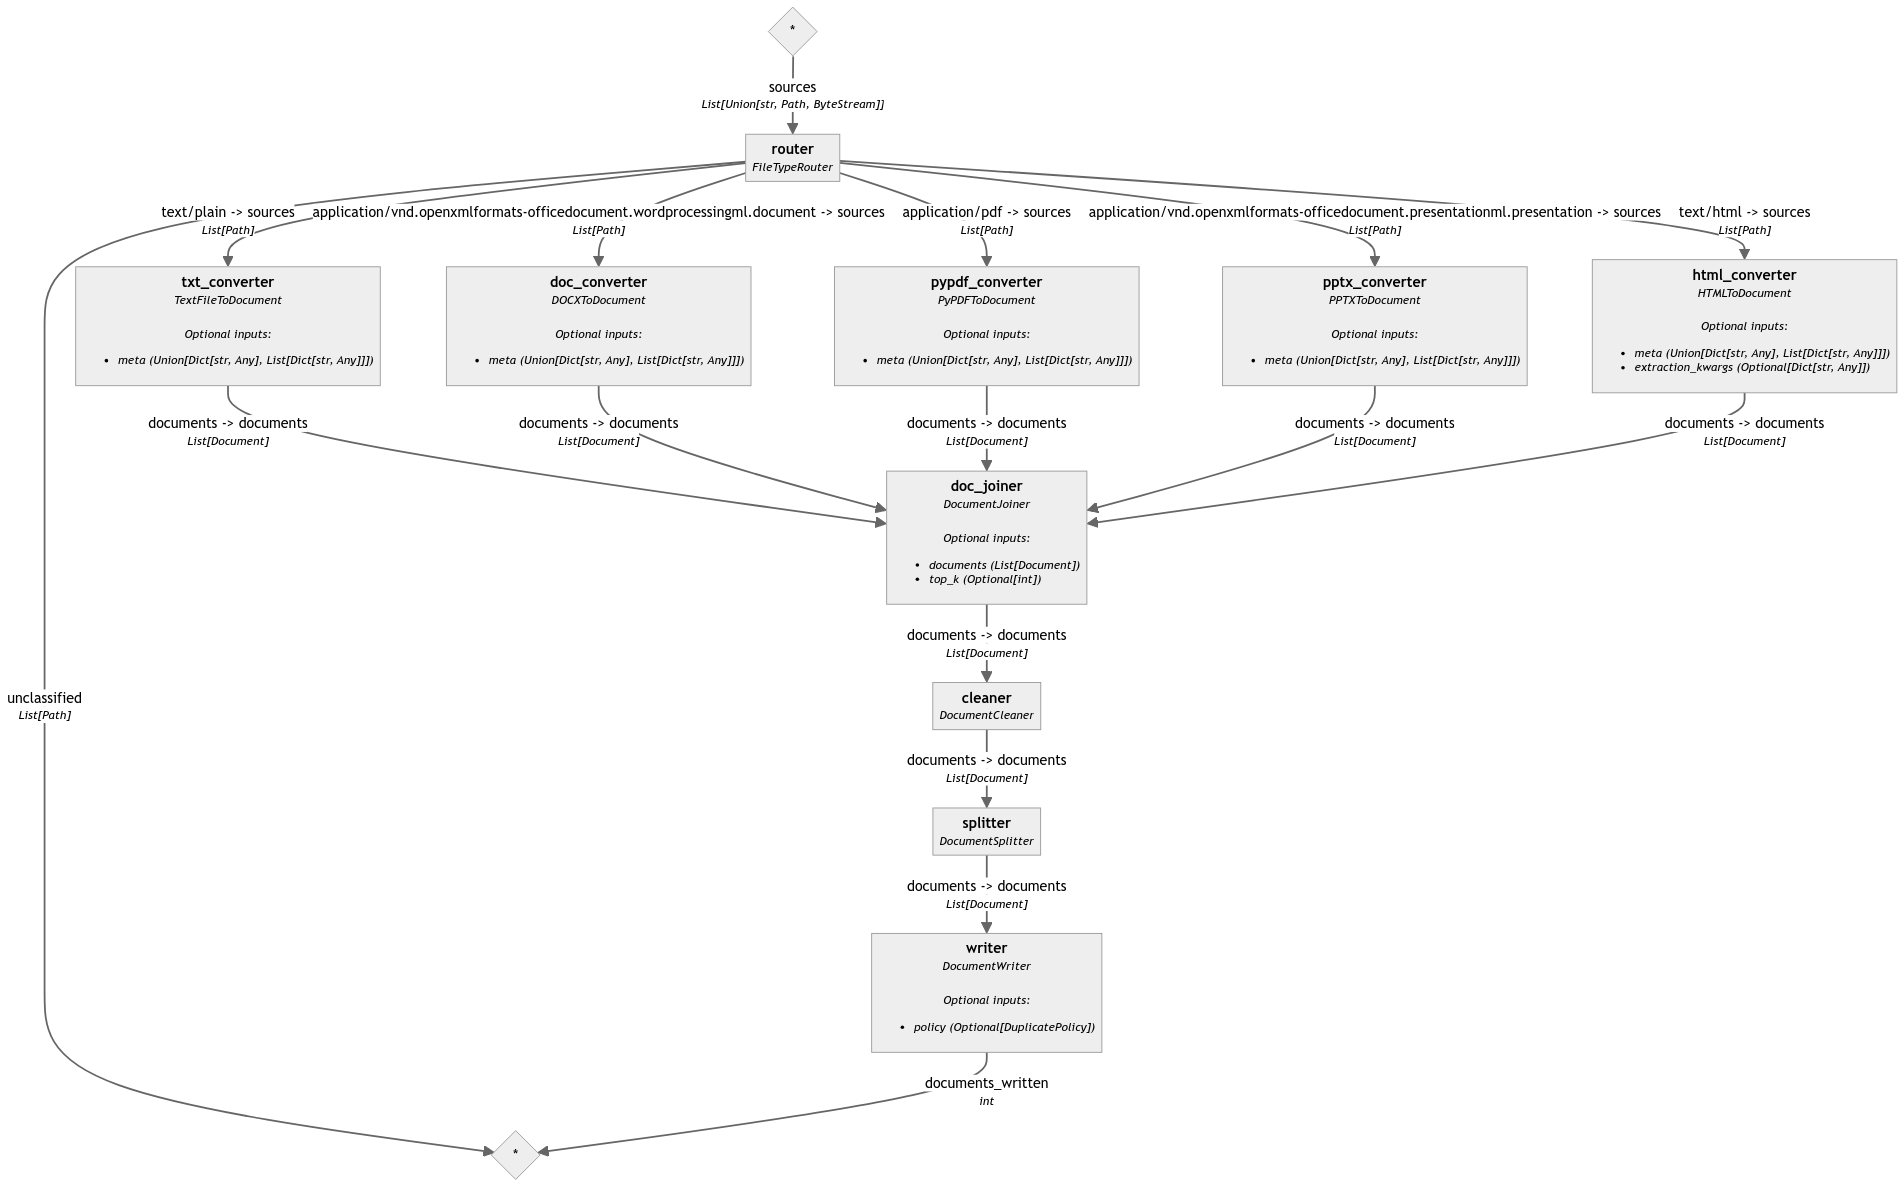

In [10]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument, DOCXToDocument, PPTXToDocument, HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

In [11]:
def indexing_pipeline(uploaded_file):
  pipeline = Pipeline()
  pipeline.add_component("router", FileTypeRouter(
      mime_types=[
          "text/plain",
          "application/pdf",
          "application/vnd.openxmlformats-officedocument.wordprocessingml.document",
          "application/vnd.openxmlformats-officedocument.presentationml.presentation",
          "text/html"]))
  pipeline.add_component("txt_converter", TextFileToDocument())
  pipeline.add_component("doc_converter", DOCXToDocument())
  pipeline.add_component("pypdf_converter", PyPDFToDocument())
  pipeline.add_component("pptx_converter", PPTXToDocument())
  pipeline.add_component("html_converter", HTMLToDocument())
  pipeline.add_component("doc_joiner", DocumentJoiner())
  pipeline.add_component("cleaner", DocumentCleaner())
  pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150, split_overlap=50))
  pipeline.add_component("writer", DocumentWriter(document_store=document_store))

  pipeline.connect("router.text/plain", "txt_converter.sources")
  pipeline.connect("router.application/vnd.openxmlformats-officedocument.wordprocessingml.document", "doc_converter.sources")
  pipeline.connect("router.application/pdf", "pypdf_converter.sources")
  pipeline.connect("router.application/vnd.openxmlformats-officedocument.presentationml.presentation", "pptx_converter.sources")
  pipeline.connect("router.text/html", "html_converter.sources")
  pipeline.connect("txt_converter", "doc_joiner")
  pipeline.connect("doc_converter", "doc_joiner")
  pipeline.connect("pypdf_converter", "doc_joiner")
  pipeline.connect("pptx_converter", "doc_joiner")
  pipeline.connect("html_converter", "doc_joiner")
  pipeline.connect("doc_joiner", "cleaner")
  pipeline.connect("cleaner", "splitter")
  pipeline.connect("splitter", "writer")
  # pipeline.show()
  return pipeline.run({"router": {"sources": uploaded_file}})

uploaded_file=["outdated_user_guide.txt","outdated_user_guide.docx","presentation.pptx","outdated_user_guide.pdf"]


### DEMO: Search each index with the context(query) "outdated" and display the results.

In [12]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

# Search and Display
for file in uploaded_file:
  indexing_pipeline([file])
  retriever = InMemoryBM25Retriever(document_store)
  result = retriever.run(query="outdated")

for r in result["documents"]:
    print(r.content + "\n")

Outdated User Guide 1. Open your computer's email client or visit the web browser and navigate to www.hotmail.com (now known as Outlook). This will take you to the sign -in page for existing accounts. 2. Locate the "Create Account" link at the bottom of the sign-in form, usually in small text. Click on it to proceed with creating a new account. 3. In the popup window that appears, enter your desired email address and password. Make sure to choose an easy -to-remember but unique combination. 4. Fill out you r personal information: First name, Last name, Country or region, Birthdate, and Gender. This will be used for account recovery purposes if needed. 5. Choose a security question from the drop -down menu and enter the answer in the provided field. This helps to verify your identity in case you forget your password. 6. Review the Microsoft Services & Software License 

Outdated User Guide 1. Open your computer's email client or visit the web browser and navigate to www.hotmail.com (now

# Indexing Pipeline for URLs

Since the pipeline lacks a splitter component, the retriever will return the entire content of the entire document.

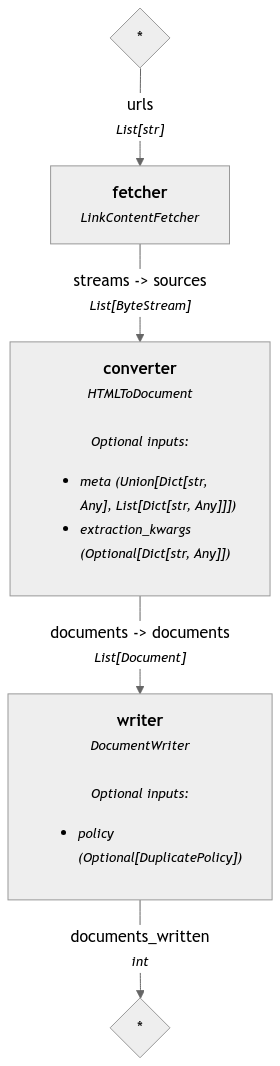

Core classes that carry data through the system.
Module answer
ExtractedAnswer
ExtractedAnswer.to_dict
def to_dict() -> Dict[str, Any]
Serialize the object to a dictionary.
Returns:
Serialized dictionary representation of the object.
ExtractedAnswer.from_dict
@classmethod
def from_dict(cls, data: Dict[str, Any]) -> "ExtractedAnswer"
Deserialize the object from a dictionary.
Arguments:
data
: Dictionary representation of the object.
Returns:
Deserialized object.
ExtractedTableAnswer
ExtractedTableAnswer.to_dict
def to_dict() -> Dict[str, Any]
Serialize the object to a dictionary.
Returns:
Serialized dictionary representation of the object.
ExtractedTableAnswer.from_dict
@classmethod
def from_dict(cls, data: Dict[str, Any]) -> "ExtractedTableAnswer"
Deserialize the object from a dictionary.
Arguments:
data
: Dictionary representation of the object.
Returns:
Deserialized object.
GeneratedAnswer
GeneratedAnswer.to_dict
def to_dict() -> Dict[str, Any]
Serialize the object to a dictionary.
R

In [13]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

document_store = InMemoryDocumentStore()

# Creating the indexing pipeline for website URLs
def url_indexing_pipeline(url):
  pipeline = Pipeline()
  pipeline.add_component("fetcher", LinkContentFetcher())
  pipeline.add_component("converter", HTMLToDocument())
  pipeline.add_component("writer", DocumentWriter(document_store = document_store))

  pipeline.connect("fetcher.streams", "converter.sources")
  pipeline.connect("converter.documents", "writer.documents")
  pipeline.show()
  pipeline.run(data={"fetcher": {"urls": url}})

# This will be a file that the user uploads
uploaded_file=["https://docs.haystack.deepset.ai/reference/data-classes-api"]

# Retrieve content
for file in uploaded_file:
  url_indexing_pipeline([file])
  retriever = InMemoryBM25Retriever(document_store)
  result = retriever.run(query="data classes")

 # Display retrieved content
for r in result["documents"]:
    print(r.content + "\n")

# Tika Converter
We can process various file types using the TikaDocumentConverter component, removing the need for the FileTypeRouter. It can not process URLs—the pipeline above will handle URLs.

https://docs.haystack.deepset.ai/docs/tikadocumentconverter

In [14]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import TikaDocumentConverter
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.core import component

In [15]:
# Initialize document store
document_store = InMemoryDocumentStore()

In [16]:
# Pipeline function for converting, cleaning, splitting/chunking, and storing text from various file types
def indexing_pipeline(uploaded_file):
    pipeline = Pipeline()
    pipeline.add_component("converter", TikaDocumentConverter())
    pipeline.add_component("cleaner", DocumentCleaner())
    # pipeline.add_component("splitter", DocumentSplitter(split_by="passage", split_length=5))
    pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
    # pipeline.add_component("splitter", DocumentSplitter(split_by="page", split_length=5))
    pipeline.add_component("writer", DocumentWriter(document_store=document_store))
    pipeline.connect("converter", "cleaner")
    pipeline.connect("cleaner", "splitter")
    pipeline.connect("splitter", "writer")
    pipeline.show()
    pipeline.run({"converter": {"sources": uploaded_file}})

# uploaded_file=["outdated_user_guide.docx"]

uploaded_file=[
    # "outdated_user_guide.txt",
    # "outdated_user_guide.docx",
    "outdated_user_guide.pdf"]


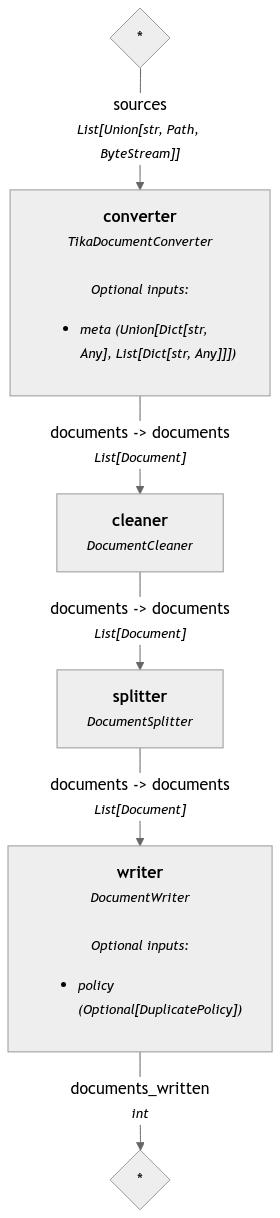

2024-09-30 00:01:01,131 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
2024-09-30 00:01:01,721 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
2024-09-30 00:01:02,056 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


Outdated User Guide 1. Open your computer's email client or visit the web browser and navigate to www.hotmail.com (now known as Outlook). This will take you to the sign-in page for existing accounts.

 2. Locate the "Create Account" link at the bottom of the sign-in form, usually in small text. Click on it to proceed with creating a new account. 3. In the popup window that appears, enter your desired email address and password.

 Make sure to choose an easy-to-remember but unique combination. 4. Fill out your personal information: First name, Last name, Country or region, Birthdate, and Gender. This will be used for account recovery purposes if needed. 5.

 Choose a security question from the drop-down menu and enter the answer in the provided field. This helps to verify your identity in case you forget your password. 6. Review the Microsoft Services & Software License Agreement, Terms of Use, Privacy Statement, and Copyright Disclaimer. If you agree with these terms, check the box nex

In [17]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

# Search and Display
for file in uploaded_file:
  indexing_pipeline([file])
  retriever = InMemoryBM25Retriever(document_store)
  result = retriever.run(query="outdated")

for r in result["documents"]:
    print(r.content + "\n")

# UnstructuredFileConverter
The UnstructuredFileConverter allows indexing one page at a time, which is particularly useful for PPTX files.

In [22]:
import os
from haystack import Pipeline
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.converters.unstructured import UnstructuredFileConverter
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from google.colab import userdata

# Unstructured API Key
UNSTRUCTURED_API_KEY = userdata.get('UNSTRUCTURED_API_KEY')
os.environ['UNSTRUCTURED_API_KEY'] = UNSTRUCTURED_API_KEY

document_store = InMemoryDocumentStore()

indexing = Pipeline()
indexing.add_component("converter", UnstructuredFileConverter(document_creation_mode="one-doc-per-page"))
indexing.add_component("writer", DocumentWriter(document_store))
indexing.connect("converter", "writer")

indexing.run({"converter": {"paths": ["presentation.pptx"]}})

Converting files to Haystack Documents: 1it [00:00,  1.17it/s]


{'writer': {'documents_written': 9}}

In [23]:
retriever = InMemoryBM25Retriever(document_store=document_store)
result = retriever.run(query="artificial intelligence")

for i, document in enumerate(result["documents"], start=1):
    print(f"{i}. {document.content}")

1. Exploring the World of Artificial Intelligence

by Myself and SlideDeck AI :)


2. Applications of Artificial Intelligence

Healthcare: AI systems can diagnose diseases and recommend treatments

Finance: AI systems can analyze financial data and make investment recommendations

Transportation: AI systems can optimize traffic flow and improve safety

AI has numerous applications in various industries, from healthcare to finance to transportation


3. History of Artificial Intelligence

AI research began in the 1950s with the Turing Test

Early AI systems used rule-based systems and expert systems

Modern AI systems use machine learning and deep learning

AI has a rich history, from rule-based systems to modern machine learning and deep learning


4. Introduction to Artificial Intelligence

AI is a branch of computer science that deals with the creation of intelligent machines

Machine learning is a subset of AI that uses algorithms to learn from data

Deep learning is a subset of mac